# RF forward modelling of sedimentary layers

In [1]:
from BayHunter.SynthObs import SynthObs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm

In [2]:
h = [5, 23, 8, 10]
vs = [2.7, 3.6, 3.8, 4.4]
vpvs = 1.73

start = -5
stop = 35
duration = stop - start
sampling_rate = 50  # Hz
x = np.linspace(start, stop, duration * sampling_rate)
rfdata = SynthObs.return_rfdata(h, vs, vpvs=vpvs, x=x)

In [3]:
def plot_1d_profile(layer_thicks, layer_velocities, ax=None):
    if ax is None:
        ax = plt.axes()
    layer_depths = np.cumsum(layer_thicks)
    layer_depths = np.concatenate(([0], layer_depths))
    if layer_depths[-1] == layer_depths[-2]:  # thickness of last layer was 0
        layer_depths[-1] += 10  # pad for the mantle
    z = np.repeat(layer_depths, 2)[1:-1]
    vs = np.repeat(layer_velocities, 2)
    ax.plot(vs, z)
    ax.invert_yaxis()
    ax.set_xlabel("$v_s$ (km/h)")
    ax.set_ylabel("Depth (km)")

def plot_rf(rfdata, ax=None):
    """
    rfdata is the output of SythObs.return_rfdata
    This will plot the P RF
    """
    if ax is None:
        ax =plt.axes()
    ax.plot(rfdata["prf"][0], rfdata["prf"][1])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("P RF")
    ax.set_yticklabels([])

def plot_synthetic(layer_thicks, layer_velocities, rfdata, gs=None):
    if gs is None:
        fig = plt.figure(layout="tight")
        gs = GridSpec(3, 4, figure=fig)
    else:
        fig = gs.figure
    ax = fig.add_subplot(gs[:, 0])
    plot_1d_profile(layer_thicks, layer_velocities, ax=ax)
    ax = fig.add_subplot(gs[1, 1:])
    plot_rf(rfdata, ax=ax)

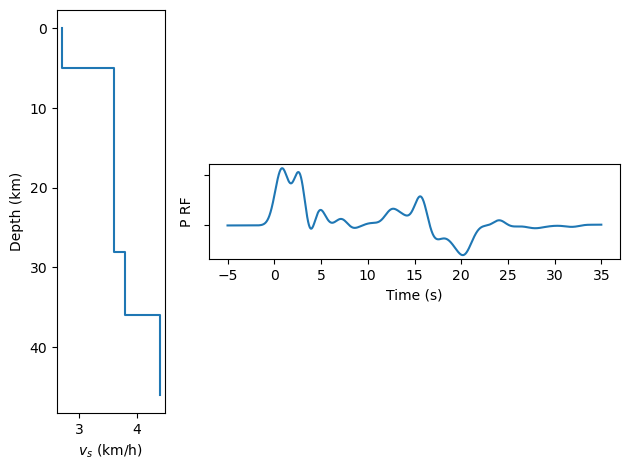

In [4]:
fig = plot_synthetic(h, vs, rfdata)

Get an average [AuSREM](http://rses.anu.edu.au/seismology/AuSREM/Downloads/downloads.php#) model

In [5]:
moho = np.loadtxt("../data/AuSREM/AusMoho2012.xyz", usecols=-1).mean()
crust = np.loadtxt("../data/AuSREM/AuSREM-C-int5km.txt", skiprows=15, comments="depth")
crust_z = np.sort(np.concatenate([[moho], np.unique(crust[:,0])]))
crust_h = crust_z[1:] - crust_z[:-1]
crust_h = np.concatenate([crust_h, [0]])
crust_vs = np.array([crust[crust[:, 0] == z, 4].mean() for z in crust_z if z < moho])
mantle = np.loadtxt("../data/AuSREM/AM4-int25km_Nov.txt", usecols=[0, 4], skiprows=17, comments="depth")
mantle_vs = mantle[mantle[:, 0] > moho, 1].mean()

ausrem_h = crust_z[1:] - crust_z[:-1]
ausrem_vs = np.concatenate([crust_vs, np.full(ausrem_h.size - crust_vs.size, mantle_vs)])

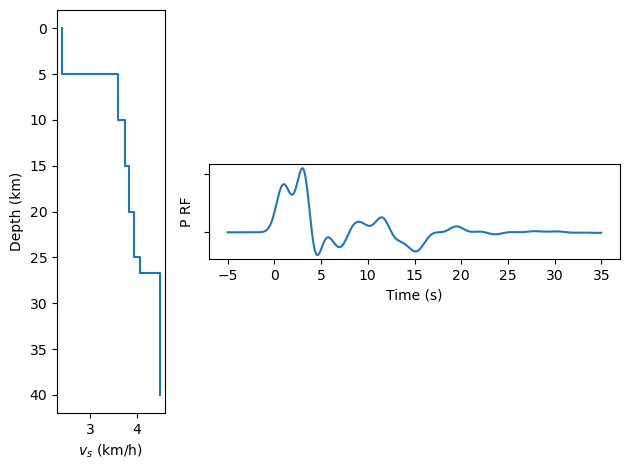

In [6]:
rfdata = SynthObs.return_rfdata(ausrem_h, ausrem_vs, vpvs=vpvs, x=x)
plot_synthetic(ausrem_h, ausrem_vs, rfdata)

In [7]:
def add_sediment_layer(h, vs, dtb):
    """
    h (km) and vs (km/h) are the thicknesses and velocities of a 1D model
    Assuming the top of the first layer is the basement, dtb is the depth
    to basement i.e. sedimentary thickness in km
    """
    sediment_velocity = 0.5  # get a ref for this
    upper_crust_h = h[0] - dtb
    h = np.concatenate([[dtb, upper_crust_h], h[1:]])
    vs = np.concatenate([[sediment_velocity], vs])
    return h, vs

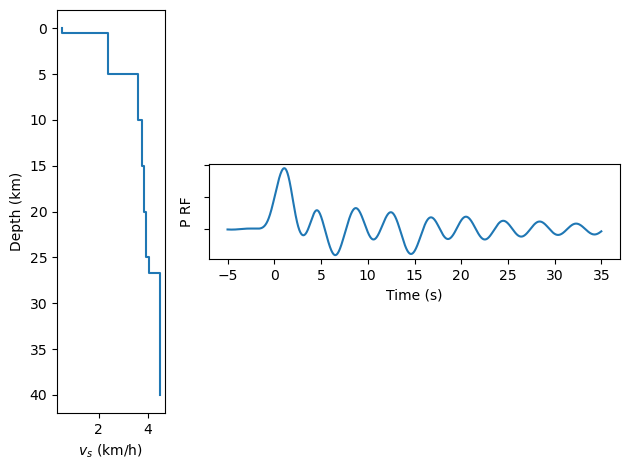

In [8]:
h, vs = add_sediment_layer(ausrem_h, ausrem_vs, 0.5)
rfdata = SynthObs.return_rfdata(h, vs, vpvs=vpvs, x=x)
plot_synthetic(h, vs, rfdata)

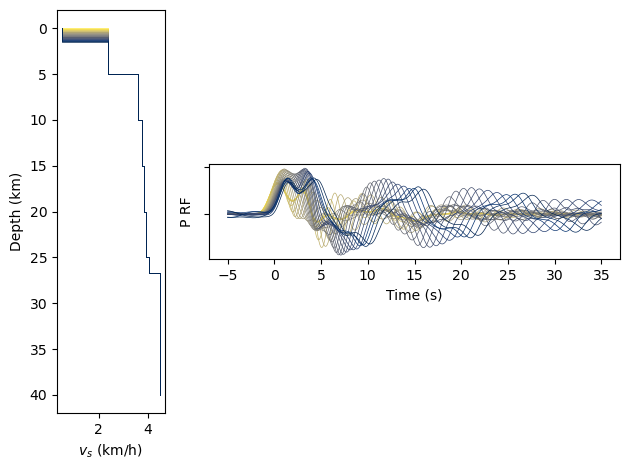

In [9]:
fig = plt.figure(layout="tight")
gs = GridSpec(3, 4, figure=fig)
model_ax = fig.add_subplot(gs[:, 0])
model_ax.invert_yaxis()
model_ax.set_xlabel("$v_s$ (km/h)")
model_ax.set_ylabel("Depth (km)")
rf_ax = fig.add_subplot(gs[1, 1:])
rf_ax.set_xlabel("Time (s)")
rf_ax.set_ylabel("P RF")
rf_ax.set_yticklabels([])

sed_thicks = np.arange(1.5, step=0.05)
cmap = cm.cividis_r(np.linspace(0, 1, len(sed_thicks)))
for i, sed_thick in enumerate(sed_thicks):
    h, vs = add_sediment_layer(ausrem_h, ausrem_vs, sed_thick)
    rfdata = SynthObs.return_rfdata(h, vs, vpvs=vpvs, x=x)

    layer_depths = np.cumsum(h)
    layer_depths = np.concatenate(([0], layer_depths))
    if layer_depths[-1] == layer_depths[-2]:  # thickness of last layer was 0
        layer_depths[-1] += 10  # pad for the mantle
    z = np.repeat(layer_depths, 2)[1:-1]
    vs = np.repeat(vs, 2)
    model_ax.plot(vs, z, c=cmap[i], linewidth=0.5)
    rf_ax.plot(rfdata["prf"][0], rfdata["prf"][1], c=cmap[i], linewidth=0.5)
